In [1]:
# import necessary libraries and data
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
total_data=pd.read_excel('/Users/nickstatz/Desktop/CornYield/ALLDATA.xlsx')
Soil=['AWC Average','CEC Average','OCD Average']
Sat=['EVI Average','NDVI Average','GCI Average','NDWI Average']
Clim=['PPT Average','MaxT Average','MeanT Average','MinT Average','vpdMax Average','vpdMin Average']

In [2]:
#split data frame into 2010-2019 and 2020
groups = total_data.groupby('Year')
test = groups.get_group(2020)
#find where 2020 starts FOUND 7976 is first 2020 value from print(total_data.loc[[7975]])
train = total_data.drop(total_data.index[7971:8864],axis=0,inplace=False)

In [3]:
# now 2010-2019 is under train and 2020 is under test
x_train_features=train[Soil+Sat+Clim].values #x values to train on
y_train_labels=train['Yield'].values                                                     #y values to train on
x_test_features=test[Soil+Sat+Clim].values   #x values to test on
y_test_labels=test['Yield'].values   #true y values to test on


In [4]:
# Features are x , Targets (labels) are y
print('Training Features Shape:', x_train_features.shape)
print('Training Labels Shape:', y_train_labels.shape)
print('Testing Features Shape:', x_test_features.shape)
print('Testing Labels Shape:', y_test_labels.shape)

Training Features Shape: (7971, 13)
Training Labels Shape: (7971,)
Testing Features Shape: (892, 13)
Testing Labels Shape: (892,)


In [5]:
# Train Model
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)
rf.fit(x_train_features, y_train_labels)

RandomForestRegressor(n_estimators=1000, random_state=0)

## Baseline

In [6]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test_features)
# Use Mean Squared Function
from sklearn.metrics import mean_squared_error
RMSE= mean_squared_error(y_test_labels, predictions, squared=False)
# Use Absolute Error
from sklearn.metrics import mean_absolute_error
MAE=mean_absolute_error(y_test_labels, predictions)
from sklearn.metrics import mean_absolute_percentage_error
MAPE=mean_absolute_percentage_error(y_test_labels, predictions)
accuracy = 100 - np.mean(MAPE)
from sklearn.metrics import r2_score
r2=r2_score(y_test_labels, predictions)

print('R2:',r2,'RMSE:', RMSE, ' MAE:',MAE, 'MAPE:',MAPE,'Accuracy:', round(accuracy, 2), '%.')

R2: 0.7650175191110851 RMSE: 15.231545591157712  MAE: 11.34986479820627 MAPE: 0.07670610498231695 Accuracy: 99.92 %.


## Hypertune

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


## Random Parameters

In [8]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train_features, y_train_labels)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [9]:
random_regressor = RandomForestRegressor(**rf_random.best_params_)
random_regressor.fit(x_train_features,y_train_labels)
random_y_pred = random_regressor.predict(x_test_features)

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
RMSE=mean_squared_error(y_test_labels, random_y_pred,squared=False) 
R2=r2_score(y_test_labels, random_y_pred)
MAE=mean_absolute_error(y_test_labels, random_y_pred)
MAPE=mean_absolute_percentage_error(y_test_labels, random_y_pred)
accuracy = 100 - np.mean(MAPE)
print('R2=',R2,' RMSE=',RMSE, ' MAE:',MAE, 'MAPE:',MAPE,'Accuracy:', round(accuracy, 2), '%.')

R2= 0.7640177383880227  RMSE= 15.263914051351328  MAE: 11.396125560538122 MAPE: 0.07712919738189618 Accuracy: 99.92 %.


## Best Parameters

In [21]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90,100,110],
    'max_features': ['auto'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [ 2, 3],
    'n_estimators': [300, 400, 500 ]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [22]:
# Fit the grid search to the data
grid_search.fit(x_train_features, y_train_labels)
grid_search.best_params_
print(grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'bootstrap': True, 'max_depth': 90, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [23]:
best_regressor = RandomForestRegressor(**grid_search.best_params_)
#**grid_search.best_params_
best_regressor.fit(x_train_features,y_train_labels)
best_y_pred = best_regressor.predict(x_test_features)

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
RMSE=mean_squared_error(y_test_labels, best_y_pred,squared=False) 
R2=r2_score(y_test_labels, best_y_pred)
MAE=mean_absolute_error(y_test_labels, best_y_pred)
MAPE=mean_absolute_percentage_error(y_test_labels, best_y_pred)
accuracy = 100 - np.mean(MAPE)
print('R2=',R2,' RMSE=',RMSE, ' MAE:',MAE, 'MAPE:',MAPE,'Accuracy:', round(accuracy, 2), '%.')

R2= 0.7651420164114724  RMSE= 15.227510104051271  MAE: 11.383164050822126 MAPE: 0.07690730922724928 Accuracy: 99.92 %.


## Plot 

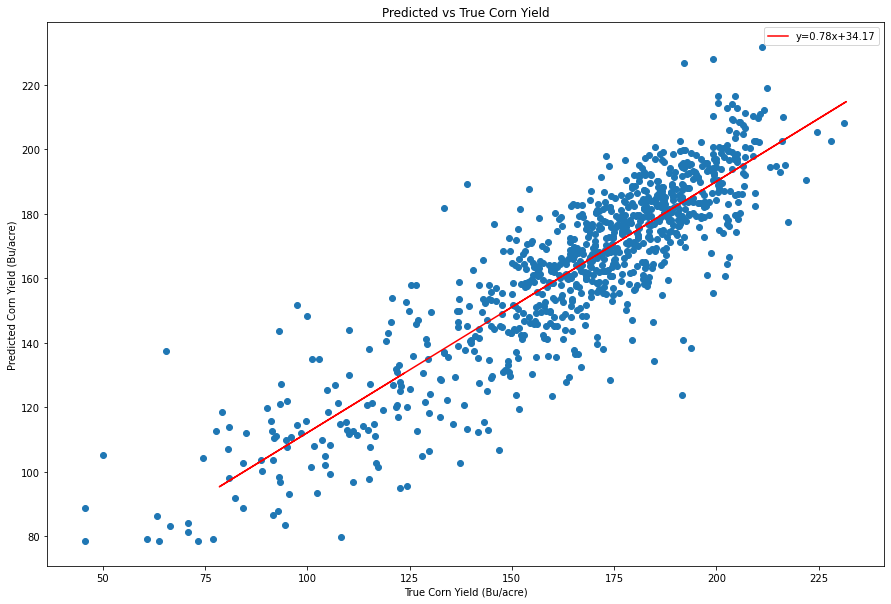

In [28]:
import matplotlib.pyplot as plt
from scipy import stats
plt.figure(figsize=(15,10))
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_labels,best_y_pred)
line = slope*best_y_pred+intercept
plt.plot(best_y_pred, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.scatter(y_test_labels,best_y_pred)
plt.title('Predicted vs True Corn Yield')
plt.xlabel('True Corn Yield (Bu/acre)')
plt.ylabel('Predicted Corn Yield (Bu/acre)')
plt.legend()
plt.show
plt.savefig("ForestBestSatSoilClim.jpeg")

In [29]:
pred_y_df=pd.DataFrame({Actual Value':y_test_labels,'Predicted Value':best_y_pred, 'Difference':y_test_labels-predictions})
pred_y_df[0:20]
pred_y_df.to_excel('RandomForestBestDif.xlsx')

In [32]:
# Get numerical feature importances
importances = list(best_regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(['AWC Average','CEC Average','OCD Average','EVI Average','NDVI Average','GCI Average','NDWI Average','PPT Average','MaxT Average','MeanT Average','MinT Average','vpdMax Average','vpdMin Average'], importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: GCI Average          Importance: 0.47
Variable: NDVI Average         Importance: 0.17
Variable: NDWI Average         Importance: 0.07
Variable: CEC Average          Importance: 0.04
Variable: MaxT Average         Importance: 0.04
Variable: AWC Average          Importance: 0.03
Variable: OCD Average          Importance: 0.03
Variable: PPT Average          Importance: 0.03
Variable: EVI Average          Importance: 0.02
Variable: MeanT Average        Importance: 0.02
Variable: MinT Average         Importance: 0.02
Variable: vpdMax Average       Importance: 0.02
Variable: vpdMin Average       Importance: 0.02
